In [2]:
import os
import shutil
import random
import pandas as pd
import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [5]:
Train_dir = "Museum_Training/Training/"
Test_dir = "Museum_Test/Museum_Validation/"

classification_targets = ['museum-indoor', 'museum-outdoor']

#   Check Directories
def check_directory(directory):
    if os.path.exists(directory):
        print(f"Directory '{directory}' exists.")
    else:
        print(f"Directory '{directory}' does NOT exist.")

check_directory(Train_dir)
check_directory(Test_dir)

Directory 'Museum_Training/Training/' exists.
Directory 'Museum_Test/Museum_Validation/' exists.


In [6]:
classification_targets = ['museum-indoor','museum-outdoor']

In [7]:
def show_dir_content(dir_content,classification_targets):
    """
    Show the number of images in each class directory within the target directory.

    """
    print(f"Contents of the directory: {dir_content}")
    for clf in classification_targets:
        clf_dir = os.path.join(dir_content, clf)
        if os.path.exists(clf_dir):
            num_images = len(os.listdir(clf_dir))
            print(f"Class '{clf}' contains {num_images} images.")
        else:
            print(f"Class directory '{clf}' does not exist.")

# Show the status of the target directory
show_dir_content(Train_dir,classification_targets)
show_dir_content(Test_dir,classification_targets)

Contents of the directory: Museum_Training/Training/
Class 'museum-indoor' contains 5000 images.
Class 'museum-outdoor' contains 5000 images.
Contents of the directory: Museum_Test/Museum_Validation/
Class 'museum-indoor' contains 100 images.
Class 'museum-outdoor' contains 100 images.


In [8]:
from PIL import Image
import numpy as np

image_sizes = []
color_modes = []

for class_name in classification_targets:
    class_dir = os.path.join(Train_dir, class_name)
    if os.path.exists(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = Image.open(img_path)
                image_sizes.append(img.size)  # (width, height)
                color_modes.append(img.mode)  # RGB, Grayscale, etc.
            except:
                print(f"Error loading {img_path}")

# Convert to DataFrame for analysis
df_sizes = pd.DataFrame(image_sizes, columns=["Width", "Height"])
df_modes = pd.DataFrame(color_modes, columns=["Color Mode"])

# Display summary
print("Image Size Distribution:")
print(df_sizes.describe())

print("\nColor Mode Counts:")
print(df_modes["Color Mode"].value_counts())

Image Size Distribution:
         Width   Height
count  10000.0  10000.0
mean     256.0    256.0
std        0.0      0.0
min      256.0    256.0
25%      256.0    256.0
50%      256.0    256.0
75%      256.0    256.0
max      256.0    256.0

Color Mode Counts:
Color Mode
RGB    10000
Name: count, dtype: int64


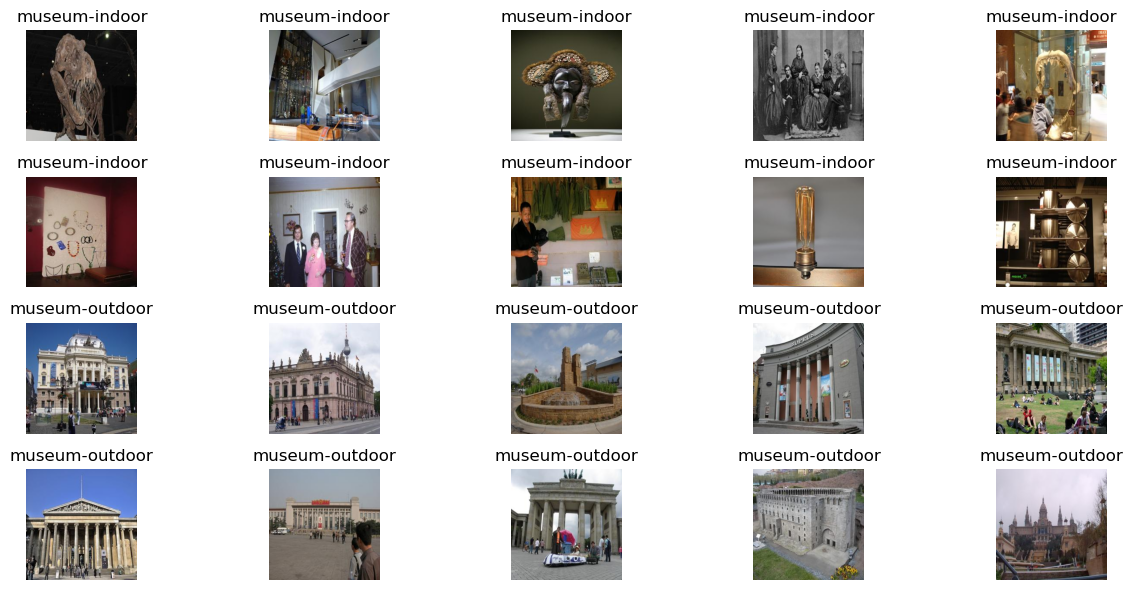

In [7]:

import matplotlib.pyplot as plt
import cv2
def show_random_images_from_train(Train_dir, classification_targets, num_images=10, images_per_row=5):
    """
    Display random images from each class in the training dataset with 5 images per row.

    Parameters:
    - Train_dir (str): Path to the training data directory.
    - classification_targets (list): List of class names (subfolders).
    - num_images (int): Number of images to display per class.
    - images_per_row (int): Number of images to display in one row.
    """
    plt.figure(figsize=(13, 6))

    for class_idx, clf in enumerate(classification_targets):
        class_path = os.path.join(Train_dir, clf)

        if not os.path.exists(class_path):
            print(f" Class folder '{clf}' does NOT exist. Skipping.")
            continue

        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        if len(image_files) == 0:
            print(f" No images found in class '{clf}'. Skipping.")
            continue

        selected_images = random.sample(image_files, min(num_images, len(image_files)))

        # Determine the number of rows needed
        rows = (num_images // images_per_row) + (num_images % images_per_row > 0)

        for i, img_name in enumerate(selected_images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                print(f" Could not read image: {img_path}. Skipping.")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB

            ax = plt.subplot(len(classification_targets) * rows, images_per_row, class_idx * rows * images_per_row + i + 1)
            plt.imshow(img)
            plt.title(f"{clf}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
# classification_targets = ["Museum_Indoor", "Museum_Outdoor"]  # Update with actual class names
show_random_images_from_train(Train_dir, classification_targets, num_images=10)

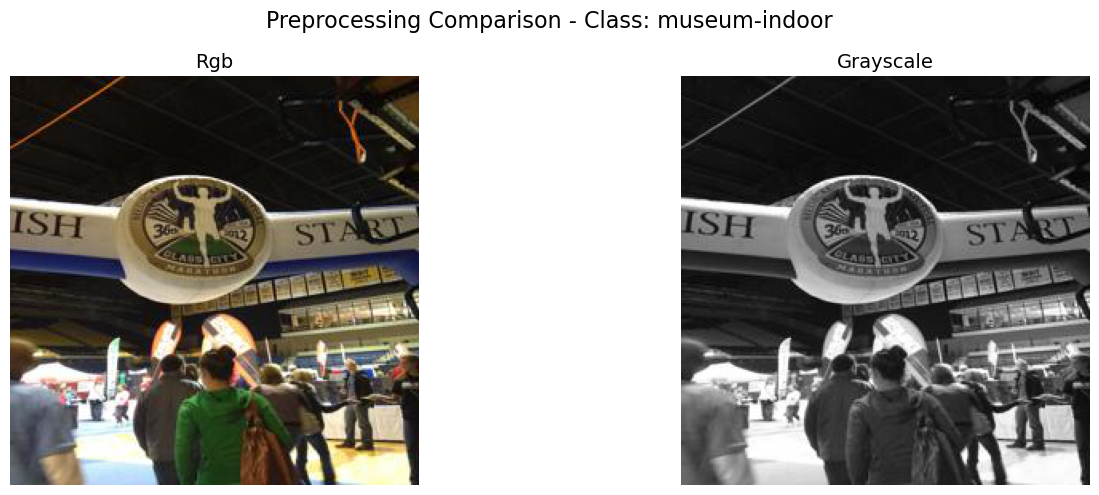

In [8]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define Preprocessing Methods
def preprocess_image(img, method):
    """Apply the selected preprocessing method to the image."""
    img = img.convert('RGB')  # Ensure image is in RGB mode
    img_array = np.array(img)
    img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)  # Convert to grayscale for non-RGB methods

    if method == 'rgb':
        return img_array  # No change (Original RGB)

    elif method == 'grayscale':
        return img_gray  # Convert to grayscale

    else:
        raise ValueError("Invalid preprocessing method! Choose from: 'rgb', 'grayscale', 'gaussian_blur'.")

# **Select a Random Image from Training Set**
def get_random_image(target_dir, classes):
    """Select a random image from the dataset."""
    class_choice = random.choice(classes)  # Pick a random class
    class_dir = os.path.join(target_dir, class_choice)
    img_name = random.choice(os.listdir(class_dir))  # Pick a random image
    img_path = os.path.join(class_dir, img_name)
    return img_path, class_choice

# **Visualize Image with Selected Preprocessing Techniques**
def visualize_preprocessing(target_dir, classes, img_size=(256, 256), figsize=(12, 4)):
    """
    Show the original and processed images for a random image.

    Parameters:
    - img_size (tuple): Resize image to this size before processing.
    - figsize (tuple): Figure size of the final plot.
    """
    img_path, selected_class = get_random_image(target_dir, classes)
    
    with Image.open(img_path) as img:
        img = img.resize(img_size)  # Resize for consistency
    
    # Define Preprocessing Methods
    methods = ['rgb', 'grayscale']
    fig, axes = plt.subplots(1, 2, figsize=figsize)  
    fig.suptitle(f"Preprocessing Comparison - Class: {selected_class}", fontsize=16)

    for i, method in enumerate(methods):
        processed_img = preprocess_image(img, method)
        ax = axes[i]  # Adjust subplot position
        cmap = 'gray' if method != 'rgb' else None  # Set grayscale colormap for non-RGB images
        ax.imshow(processed_img, cmap=cmap)
        ax.set_title(method.replace("_", " ").capitalize(), fontsize=14)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# **Run Visualization**
visualize_preprocessing(Train_dir, classification_targets, img_size=(256, 256), figsize=(15, 5))


In [9]:
def is_image_file(filename):
    """
    Check if a file is an image based on its extension.
    """
    valid_extensions = ('.jpg', '.jpeg', '.png')
    return filename.lower().endswith(valid_extensions)

def preprocess_images(target_dir, classes, image_size=(256,256)):
    """
    Preprocess images: resize, convert to grayscale (optional), and flatten.

    Parameters:
    - target_dir (str): Path to the target directory containing class folders.
    - classes (list of str): List of class names.
    - image_size (tuple): Desired image size (width, height).

    Returns:
    - X (numpy.ndarray): Flattened image data.
    - y (numpy.ndarray): Corresponding labels.

    """
    X = []
    y = []

    for label, cls in enumerate(classes):
        class_dir = os.path.join(target_dir, cls)
        for img_name in os.listdir(class_dir):
            if is_image_file(img_name):
                img_path = os.path.join(class_dir, img_name)
                try:
                    with Image.open(img_path) as img:
                        img = img.convert('RGB')  # Ensure image is in RGB mode
                        img = img.resize(image_size)  # Resize image
                        img_array = np.array(img).flatten()  # Flatten the image
                        X.append(img_array)
                        y.append(label)
                except Exception as e:
                    print(f"Error processing file {img_path}: {e}")

    X = np.array(X)
    y = np.array(y)
    return X, y


# Preprocess images
X, y = preprocess_images(Train_dir, classification_targets)
print("Image data shape:", X.shape)
print("Labels shape:", y.shape)

Image data shape: (10000, 196608)
Labels shape: (10000,)


In [17]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)
print("Image data shape:", x_scaled.shape)

Image data shape: (10000, 196608)


In [1]:
def preprocess_images_grayscale(target_dir, classes, image_size=(256, 256)):
    """
    Preprocess images: Convert to grayscale, resize, and flatten.

    Parameters:
    - target_dir (str): Path to the target directory containing class folders.
    - classes (list of str): List of class names.
    - image_size (tuple): Target image size (width, height).

    Returns:
    - X_gray (numpy.ndarray): Flattened grayscale image data.
    - y_gray (numpy.ndarray): Corresponding labels.
    """
    X_grey = []
    y_grey = []

    for label, cls in enumerate(classes):
        class_dir = os.path.join(target_dir, cls)
        for img_name in os.listdir(class_dir):
            if is_image_file(img_name):
                img_path = os.path.join(class_dir, img_name)
                try:
                    # Open Image
                    with Image.open(img_path) as img:
                        img = img.convert('L')  # Convert to grayscale
                        img = img.resize(image_size)  # Resize to desired size
                        img_array = np.array(img).flatten()  # Flatten the image

                        X_grey.append(img_array)
                        y_grey.append(label)

                except Exception as e:
                    print(f"Error processing file {img_path}: {e}")

    X_grey = np.array(X_grey)
    y_grey = np.array(y_grey)
    return X_grey, y_grey

# **Preprocess Grayscale Images**
X_grey, y_grey = preprocess_images_grayscale(Train_dir, classification_targets)

# **Print Feature Shapes**
print("\nGrayscale Image Data Shape:", X_grey.shape)
print("Labels Shape:", y_grey.shape)

NameError: name 'Train_dir' is not defined

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (8000, 196608)
Testing data shape: (2000, 196608)


In [ ]:
X_grey_train, X_grey_test, y_grey_train, y_grey_test = train_test_split(X_grey, y_grey, test_size=0.2, random_state=42)
print("Training data shape:", X_grey_train.shape)
print("Testing data shape:", X_grey_test.shape)

Training data shape: (8000, 65536)
Testing data shape: (2000, 65536)


In [18]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(x_scaled, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train_scaled.shape)
print("Testing data shape:", X_test_scaled.shape)

Training data shape: (8000, 196608)
Testing data shape: (2000, 196608)


In [10]:
# Define and train model
dt_model_entropy = DecisionTreeClassifier(max_depth=6)
dt_model_entropy.fit(X_train, y_train)

# Predictions
y_train_pred = dt_model_entropy.predict(X_train)
y_test_pred = dt_model_entropy.predict(X_test)

# Metrics (Train)
precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_train_pred, average='weighted')
accuracy_train = accuracy_score(y_train, y_train_pred)
cm_train = confusion_matrix(y_train, y_train_pred)

# Metrics (Test)
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
accuracy_test = accuracy_score(y_test, y_test_pred)
cm_test = confusion_matrix(y_test, y_test_pred)


# Print results
print('--- Training Metrics ---')
print(f'Accuracy: {accuracy_train:.4f}')
print(f'Precision: {precision_train:.4f}')
print(f'Recall: {recall_train:.4f}')
print(f'F1-Score: {f1_train:.4f}')
print('Confusion Matrix:\n', cm_train)

print('\n--- Testing Metrics ---')
print(f'Accuracy: {accuracy_test:.4f}')
print(f'Precision: {precision_test:.4f}')
print(f'Recall: {recall_test:.4f}')
print(f'F1-Score: {f1_test:.4f}')
print('Confusion Matrix:\n', cm_test)

--- Training Metrics ---
Accuracy: 0.9141
Precision: 0.9156
Recall: 0.9141
F1-Score: 0.9141
Confusion Matrix:
 [[3774  226]
 [ 461 3539]]

--- Testing Metrics ---
Accuracy: 0.8485
Precision: 0.8512
Recall: 0.8485
F1-Score: 0.8482
Confusion Matrix:
 [[892 108]
 [195 805]]


In [ ]:
import numpy as np
import os
import cv2
from PIL import Image

# Define path for new test images
# new_test_dir = "/content/new_test_images"  # Change to actual test folder path
image_size = (256, 256)  # Ensure same size as training

def is_image_file(filename):
    """Check if a file is an image based on its extension."""
    valid_extensions = ('.jpg', '.jpeg', '.png')
    return filename.lower().endswith(valid_extensions)

def preprocess_new_images(test_dir, classes):
    """
    Preprocess new test images using RGB format (No grayscale, No transformations).

    Parameters:
    - test_dir (str): Path to the test images.
    - classes (list): List of class labels.

    Returns:
    - X_test (numpy.ndarray): Processed image data.
    - y_test (numpy.ndarray): Corresponding true labels.
    - file_names (list): List of image file names for reference.
    """
    X_test = []
    y_test = []
    file_names = []

    for label, cls in enumerate(classes):
        class_dir = os.path.join(test_dir, cls)
        if not os.path.exists(class_dir):
            print(f"⚠️ Warning: Directory '{class_dir}' does not exist!")
            continue

        for img_name in os.listdir(class_dir):
            if is_image_file(img_name):
                img_path = os.path.join(class_dir, img_name)
                try:
                    with Image.open(img_path) as img:
                        img = img.convert('RGB')  # Convert to RGB
                        img = img.resize(image_size)  # Resize image
                        img_array = np.array(img).flatten()  # Flatten image to store as a feature vector

                        X_test.append(img_array)
                        y_test.append(label)
                        file_names.append(img_name)

                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    return np.array(X_test), np.array(y_test), file_names

# **Preprocess New Test Images**
X_test_new, y_test_new, test_files = preprocess_new_images(Test_dir, classification_targets)

print(f"\n Processed {len(test_files)} new test images!")
print("New test data shape:", X_test_new.shape)
print("Labels shape:", y_test_new.shape)


✅ Processed 200 new test images!
New test data shape: (200, 196608)
Labels shape: (200,)


In [21]:
y_pred_test = dt_model_entropy.predict(X_test_new)
predicted_classes = [classification_targets[i] for i in y_pred_test]
actual_classes = [classification_targets[i] for i in y_pred_test]

In [ ]:
for i in range(min(50, len(test_files))):  # Show first 10 results
    print(f" Image: {test_files[i]} | Actual: {actual_classes[i]} | Predicted: {predicted_classes[i]}")

🖼️ Image: Places365_val_00000425.jpg | Actual: museum-indoor | Predicted: museum-indoor
🖼️ Image: Places365_val_00000665.jpg | Actual: museum-indoor | Predicted: museum-indoor
🖼️ Image: Places365_val_00000826.jpg | Actual: museum-indoor | Predicted: museum-indoor
🖼️ Image: Places365_val_00000846.jpg | Actual: museum-indoor | Predicted: museum-indoor
🖼️ Image: Places365_val_00000962.jpg | Actual: museum-indoor | Predicted: museum-indoor
🖼️ Image: Places365_val_00001187.jpg | Actual: museum-indoor | Predicted: museum-indoor
🖼️ Image: Places365_val_00001351.jpg | Actual: museum-indoor | Predicted: museum-indoor
🖼️ Image: Places365_val_00001480.jpg | Actual: museum-indoor | Predicted: museum-indoor
🖼️ Image: Places365_val_00001538.jpg | Actual: museum-indoor | Predicted: museum-indoor
🖼️ Image: Places365_val_00001633.jpg | Actual: museum-indoor | Predicted: museum-indoor
🖼️ Image: Places365_val_00001751.jpg | Actual: museum-outdoor | Predicted: museum-outdoor
🖼️ Image: Places365_val_000020

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Compute Metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test_new, y_pred_test, average='weighted')
accuracy = accuracy_score(y_test_new, y_pred_test)
cm = confusion_matrix(y_test_new, y_pred_test)

# Print Evaluation Results
print("\nEvaluation on New Test Images ---")
print(f'🔹 Accuracy: {accuracy:.4f}')
print(f'🔹 Precision: {precision:.4f}')
print(f'🔹 Recall: {recall:.4f}')
print(f'🔹 F1-Score: {f1:.4f}')
print('Confusion Matrix:\n', cm)


--- 📊 Evaluation on New Test Images ---
🔹 Accuracy: 0.8550
🔹 Precision: 0.8550
🔹 Recall: 0.8550
🔹 F1-Score: 0.8550
Confusion Matrix:
 [[86 14]
 [15 85]]


In [ ]:
# Identify incorrect predictions
wrong_indices = np.where(y_pred_test != y_test_new)[0]  # Indices where predictions are wrong

# Convert labels to class names
predicted_classes = [classification_targets[i] for i in y_pred_test]
actual_classes = [classification_targets[i] for i in y_test_new]

# Print wrong predictions
print("\n Misclassified Images:")
for i in wrong_indices[:10]:  # Print first 10 misclassified images
    print(f"Image: {test_files[i]} | Actual: {actual_classes[i]} | Predicted: {predicted_classes[i]}")



 Misclassified Images:
🖼️ Image: Places365_val_00001751.jpg | Actual: museum-indoor | Predicted: museum-outdoor
🖼️ Image: Places365_val_00002325.jpg | Actual: museum-indoor | Predicted: museum-outdoor
🖼️ Image: Places365_val_00003470.jpg | Actual: museum-indoor | Predicted: museum-outdoor
🖼️ Image: Places365_val_00003535.jpg | Actual: museum-indoor | Predicted: museum-outdoor
🖼️ Image: Places365_val_00004461.jpg | Actual: museum-indoor | Predicted: museum-outdoor
🖼️ Image: Places365_val_00006164.jpg | Actual: museum-indoor | Predicted: museum-outdoor
🖼️ Image: Places365_val_00006502.jpg | Actual: museum-indoor | Predicted: museum-outdoor
🖼️ Image: Places365_val_00016252.jpg | Actual: museum-indoor | Predicted: museum-outdoor
🖼️ Image: Places365_val_00017097.jpg | Actual: museum-indoor | Predicted: museum-outdoor
🖼️ Image: Places365_val_00018699.jpg | Actual: museum-indoor | Predicted: museum-outdoor


In [15]:
# Define and train model
dt_model_grey = DecisionTreeClassifier(max_depth=4)
dt_model_grey.fit(X_grey_train, y_grey_train)

# Predictions
y_train_pred_grey = dt_model_grey.predict(X_grey_train)
y_test_pred_grey = dt_model_grey.predict(X_grey_test)

# Metrics (Train)
precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_grey_train, y_train_pred_grey, average='weighted')
accuracy_train = accuracy_score(y_grey_train, y_train_pred_grey)
cm_train = confusion_matrix(y_grey_train, y_train_pred_grey)

# Metrics (Test)
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_grey_test, y_test_pred_grey, average='weighted')
accuracy_test = accuracy_score(y_grey_test, y_test_pred_grey)
cm_test = confusion_matrix(y_grey_test, y_test_pred_grey)


# Print results
print('--- Training Metrics ---')
print(f'Accuracy: {accuracy_train:.4f}')
print(f'Precision: {precision_train:.4f}')
print(f'Recall: {recall_train:.4f}')
print(f'F1-Score: {f1_train:.4f}')
print('Confusion Matrix:\n', cm_train)

print('\n--- Testing Metrics ---')
print(f'Accuracy: {accuracy_test:.4f}')
print(f'Precision: {precision_test:.4f}')
print(f'Recall: {recall_test:.4f}')
print(f'F1-Score: {f1_test:.4f}')
print('Confusion Matrix:\n', cm_test)

--- Training Metrics ---
Accuracy: 0.6863
Precision: 0.7095
Recall: 0.6863
F1-Score: 0.6770
Confusion Matrix:
 [[2063 1925]
 [ 585 3427]]

--- Testing Metrics ---
Accuracy: 0.6265
Precision: 0.6466
Recall: 0.6265
F1-Score: 0.6151
Confusion Matrix:
 [[460 552]
 [195 793]]


In [19]:
# Define and train model
dt_model_scaled = DecisionTreeClassifier(max_depth=6)
dt_model_scaled.fit(X_train_scaled, y_train_scaled)

# Predictions
y_train_pred_scaled = dt_model_scaled.predict(X_train_scaled)
y_test_pred_scaled = dt_model_scaled.predict(X_test_scaled)

# Metrics (Train)
precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train_scaled, y_train_pred_scaled, average='weighted')
accuracy_train = accuracy_score(y_train_scaled, y_train_pred_scaled)
cm_train = confusion_matrix(y_train_scaled, y_train_pred_scaled)

# Metrics (Test)
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test_scaled, y_test_pred_scaled, average='weighted')
accuracy_test = accuracy_score(y_test_scaled, y_test_pred_scaled)
cm_test = confusion_matrix(y_test_scaled, y_test_pred_scaled)


# Print results
print('--- Training Metrics ---')
print(f'Accuracy: {accuracy_train:.4f}')
print(f'Precision: {precision_train:.4f}')
print(f'Recall: {recall_train:.4f}')
print(f'F1-Score: {f1_train:.4f}')
print('Confusion Matrix:\n', cm_train)

print('\n--- Testing Metrics ---')
print(f'Accuracy: {accuracy_test:.4f}')
print(f'Precision: {precision_test:.4f}')
print(f'Recall: {recall_test:.4f}')
print(f'F1-Score: {f1_test:.4f}')
print('Confusion Matrix:\n', cm_test)

--- Training Metrics ---
Accuracy: 0.9126
Precision: 0.9128
Recall: 0.9126
F1-Score: 0.9126
Confusion Matrix:
 [[3684  304]
 [ 395 3617]]

--- Testing Metrics ---
Accuracy: 0.8420
Precision: 0.8420
Recall: 0.8420
F1-Score: 0.8420
Confusion Matrix:
 [[860 152]
 [164 824]]


In [12]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Define and train the Random Forest model
rf_model = RandomForestClassifier(max_depth=6,n_estimators=10, criterion='entropy', random_state=42)  # Using 100 trees
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Metrics (Train)
precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_train_pred, average='weighted')
accuracy_train = accuracy_score(y_train, y_train_pred)
cm_train = confusion_matrix(y_train, y_train_pred)

# Metrics (Test)
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
accuracy_test = accuracy_score(y_test, y_test_pred)
cm_test = confusion_matrix(y_test, y_test_pred)


# Print Training Metrics
print('--- Training Metrics ---')
print(f'Accuracy: {accuracy_train:.4f}')
print(f'Precision: {precision_train:.4f}')
print(f'Recall: {recall_train:.4f}')
print(f'F1-Score: {f1_train:.4f}')
print('Confusion Matrix:\n', cm_train)

# Print Testing Metrics
print('\n--- Testing Metrics ---')
print(f'Accuracy: {accuracy_test:.4f}')
print(f'Precision: {precision_test:.4f}')
print(f'Recall: {recall_test:.4f}')
print(f'F1-Score: {f1_test:.4f}')
print('Confusion Matrix:\n', cm_test)

--- Training Metrics ---
Accuracy: 0.9169
Precision: 0.9182
Recall: 0.9169
F1-Score: 0.9168
Confusion Matrix:
 [[3780  220]
 [ 445 3555]]

--- Testing Metrics ---
Accuracy: 0.8905
Precision: 0.8920
Recall: 0.8905
F1-Score: 0.8904
Confusion Matrix:
 [[921  79]
 [140 860]]


In [1]:
import os
import numpy as np
import xgboost as xgb
from sklearn.utils import shuffle
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from PIL import Image

# Define Paths
Train_dir = "Museum_Training/Training/"
Test_dir = "Museum_Test/Museum_Validation/"

classification_targets = ['museum-indoor', 'museum-outdoor']

# Function to Check Directories
def check_directory(directory):
    if os.path.exists(directory):
        print(f"Directory '{directory}' exists.")
    else:
        print(f"Directory '{directory}' does NOT exist.")

check_directory(Train_dir)
check_directory(Test_dir)

# Function to Load & Preprocess Images
def is_image_file(filename):
    valid_extensions = ('.jpg', '.jpeg', '.png')
    return filename.lower().endswith(valid_extensions)

def preprocess_images(target_dir, classes, image_size=(128, 128)):
    """ Load images, resize, flatten into feature vectors. """
    X, y = [], []
    for label, cls in enumerate(classes):
        class_dir = os.path.join(target_dir, cls)
        for img_name in os.listdir(class_dir):
            if is_image_file(img_name):
                img_path = os.path.join(class_dir, img_name)
                try:
                    with Image.open(img_path) as img:
                        img = img.convert('RGB')
                        img = img.resize(image_size)
                        img_array = np.array(img).astype(np.uint8)  # No Normalization
                        X.append(img_array.flatten())
                        y.append(label)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    return np.array(X), np.array(y)

# Load & Preprocess Images
X, y = preprocess_images(Train_dir, classification_targets)
print(f"Image data shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Define XGBoost Parameters (Using GPU)
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,  # Increased depth for more learning
    'learning_rate':0.1 ,  # Lower learning rate for stability
    'eval_metric': 'logloss',
    'tree_method': 'hist',  # Histogram method (efficient for large datasets)
    'device': 'cuda'  # Enable GPU acceleration
}

# Batch Training
batch_size = 1000
num_batches = (len(X_train) + batch_size - 1) // batch_size
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)
batch_predictions = []
train_predictions = []

print("\nStarting XGBoost Batch Training with GPU...\n")

final_model = None  # Store final trained model

for i in range(num_batches):
    start, end = i * batch_size, min((i + 1) * batch_size, len(X_train))
    X_batch, y_batch = X_train_shuffled[start:end], y_train_shuffled[start:end]

    if len(X_batch) == 0:
        continue

    print(f"Training Batch {i+1}/{num_batches} with {len(X_batch)} samples")

    # Train XGBoost Model on Batch
    dtrain_batch = xgb.DMatrix(X_batch, label=y_batch)
    final_model = xgb.train(params, dtrain_batch, num_boost_round=10)  # Update final model

# Use the final trained model for predictions
dtest = xgb.DMatrix(X_test)
dtrain = xgb.DMatrix(X_train)

y_test_pred_prob = final_model.predict(dtest)
y_train_pred_prob = final_model.predict(dtrain)

# Convert probabilities to binary predictions
y_test_pred = (y_test_pred_prob > 0.5).astype(int)
y_train_pred = (y_train_pred_prob > 0.5).astype(int)

print("\nBatch Training Complete!\n")

# Evaluate Test Performance
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
cm_test = confusion_matrix(y_test, y_test_pred)

# Evaluate Train Performance
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_train_pred, average='weighted')
cm_train = confusion_matrix(y_train, y_train_pred)

# Print Results
print("\n------------------Your name and student ID------------------------")
print("Name: ", "Aditya Sawant", "Student ID: ", "40311540")

print("\n--- Training Metrics ---")
print(f'Accuracy: {accuracy_train:.4f}')
print(f'Precision: {precision_train:.4f}')
print(f'Recall: {recall_train:.4f}')
print(f'F1-Score: {f1_train:.4f}')
print('Confusion Matrix:\n', cm_train)

print("\n--- Final Testing Metrics ---")
print(f'Accuracy: {accuracy_test:.4f}')
print(f'Precision: {precision_test:.4f}')
print(f'Recall: {recall_test:.4f}')
print(f'F1-Score: {f1_test:.4f}')
print('Confusion Matrix:\n', cm_test)

Directory 'Museum_Training/Training/' exists.
Directory 'Museum_Test/Museum_Validation/' exists.
Image data shape: (10000, 49152)
Labels shape: (10000,)
Training data shape: (8000, 49152)
Testing data shape: (2000, 49152)

Starting XGBoost Batch Training with GPU...

Training Batch 1/8 with 1000 samples
Training Batch 2/8 with 1000 samples
Training Batch 3/8 with 1000 samples
Training Batch 4/8 with 1000 samples
Training Batch 5/8 with 1000 samples
Training Batch 6/8 with 1000 samples
Training Batch 7/8 with 1000 samples
Training Batch 8/8 with 1000 samples

Batch Training Complete!


------------------Your name and student ID------------------------
Name:  Aditya Sawant Student ID:  40311540

--- Training Metrics ---
Accuracy: 0.8638
Precision: 0.8640
Recall: 0.8638
F1-Score: 0.8637
Confusion Matrix:
 [[3401  599]
 [ 491 3509]]

--- Final Testing Metrics ---
Accuracy: 0.8585
Precision: 0.8590
Recall: 0.8585
F1-Score: 0.8585
Confusion Matrix:
 [[840 160]
 [123 877]]
